# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

You can use `pyarabic` or any other library to pre-process and clean the Arabic text.

In [1]:
!pip install PyArabic
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 7.7 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
import pyarabic.araby as araby
import nltk

# Download the Dataset

Please note that you are allowed to take a subset of this dataset, the reason for that is it might take a long time to train the model on.

In [3]:
!kaggle datasets download -d khaledzsa/sanad
!unzip sanad.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/sanad
License(s): unknown
 98% 70.0M/71.4M [00:04<00:00, 24.4MB/s]
100% 71.4M/71.4M [00:04<00:00, 17.9MB/s]
Archive:  sanad.zip
  inflating: sanad.csv               


In [4]:
df = pd.read_csv('sanad.csv')

# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [5]:
#Inspect the Data:
df.head()

,text,label
0,https://example.com/resource/الشاٌرقة -ْ محمِد...,Culture
1,https://example.com/resource/اَنِطٌلقّتَ ٍفٍيّ...,Culture
2,https://example.com/resource/أُقيًمٌتِ مِساءُ ...,Culture
3,https://example.com/resource/بٍاسُمةَ يًوٌنٍس ...,Culture
4,https://example.com/resource/قُرر اَتحِاد اًلْ...,Culture


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39885 entries, 0 to 39884
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39885 non-null  object
 1   label   39885 non-null  object
dtypes: object(2)
memory usage: 623.3+ KB


In [7]:
#Check for Missing Values:
df.isnull().sum()

,0
text,0
label,0


<Axes: xlabel='label'>

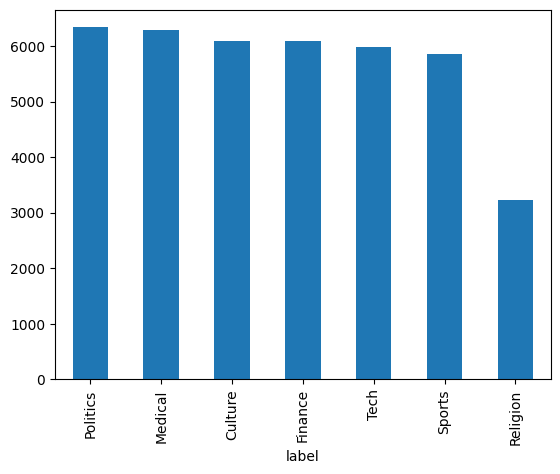

In [8]:
#Distribution of Labels:
df['label'].value_counts().plot(kind='bar')

<Axes: >

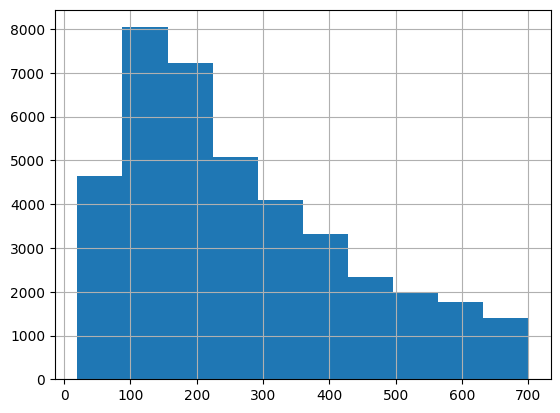

In [9]:
#Text Data Characteristics (Bonus):
df['words_count'] = df['text'].apply(lambda x: len(x.split()))
df['words_count'].hist()

In [10]:
df['words_count'].max()

700

In [11]:
df['words_count'].min()

20

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **Arabic stopwords loading**:
   We load a list of Arabic stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   - **Removing links (URLs)**: Any URLs present in the text are removed as they are not meaningful for classification purposes.
   - **Removing special characters and punctuation**: This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   - **Removing Arabic diacritics (Tashkeel) and elongated letters (Tatweel)**: Diacritical marks and elongated letters are stripped out to standardize the text.
   - **Removing Arabic stopwords**: Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   - **Stemming or Lemmmatization**: Either stemming or lemmatization is applied to reduce words to their root or base form.
   - **Normalizing Hamza**: Any variation of the Hamza character is normalized for consistency.

   **Note:** Most of these you can do using the library [PyArabic](https://pyarabic.readthedocs.io/ar/latest/README.html#features)

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [12]:
#Remove missing values:
#no missing values

In [13]:
#Filter by text length (Bonus):
min_len = 20
max_len = 550
df = df[df['words_count'].between(min_len, max_len)]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36337 entries, 1 to 39884
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         36337 non-null  object
 1   label        36337 non-null  object
 2   words_count  36337 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
#Arabic stopwords loading:
stopword = set(stopwords.words('arabic'))

In [17]:
from nltk.stem.isri import ISRIStemmer

#Text cleaning:
def clean_text(text):
  #Removing links (URLs):
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

  #Removing special characters and punctuation:
  text = re.sub(r'[^\w\s]', '', text)

  #Removing Arabic diacritics (Tashkeel) and elongated letters (Tatweel):
  text = araby.strip_tashkeel(text)
  text = araby.strip_tatweel(text)

  #Removing Arabic stopwords:
  #tokenize first so we can go through the text word by word
  words = araby.tokenize(text)
  #remove the stopwords now
  words_no_sw = [word for word in words if word not in stopword]

  #Stemming or Lemmmatization:
  stemmer =ISRIStemmer()
  stem_words = [stemmer.stem(word) for word in words_no_sw]

  #join back the words
  text = ' '.join(stem_words)

  #Normalizing Hamza:
  text = araby.normalize_hamza(text)

  #return the text
  return text

#perform the clean_text function
df['text'] = df['text'].apply(clean_text)

In [18]:
df.sample(10)

,text,label,words_count
14613,خليجءعلنت هيء صحة بدب مدد ساع عمل ركز حيص فحص ...,Medical,123
11603,ءشر سوق وظب ورق الة نسب 29 0 وصل 2486 نقط بلغ ...,Finance,180
25147,حفظ شر ظلم ظلم شيط ارد نفس مرة سوء قلب صخر جلم...,Religion,213
10563,بنك شرق شرء 425 سهم يوم اول بلغ توسط سعر شرء س...,Finance,31
5613,تحد كتب ءدباء امر فرع وظب مسي قصص فرح ريد سور ...,Culture,145
22088,صحف 187التايمز171 بريطانية اير نفق لير دولار د...,Politics,137
3608,ركز شرق شعر شعب احتفالية نسب رور 90 عما وفة شع...,Culture,221
6768,خليجسجل سوق وظب رفع جيد نسب 62 0 غلق 1 4847 نق...,Finance,231
6498,جلس درة شرك تعد عرب سعد عدن جمع عمة عدي وفق زي...,Finance,102
22332,هيء علماء سلم جهت سيس وءقليمية ضلع حدث جرم فجر...,Politics,72


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

#Tokenization:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [20]:
#Text to sequences:
sequences = tokenizer.texts_to_sequences(df['text'])

In [21]:
from tensorflow.keras.utils import pad_sequences

#Padding the sequences:
pad_seq = pad_sequences(sequences, maxlen=max_len, padding='post')

In [22]:
from sklearn.preprocessing import LabelEncoder

#Label encoding:
encoder = LabelEncoder()
labels = encoder.fit_transform(df['label'])

In [23]:
from sklearn.model_selection import train_test_split

#Train-test split:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, labels, test_size=0.2, random_state=42)

In [24]:
#Data shape confirmation:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((29069, 550), (29069,), (7268, 550), (7268,))

# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Bidirectional, SimpleRNN, Dense

In [26]:
#for the embedding layer input
vocab_size = len(tokenizer.word_index) + 1

In [27]:
#Model Type:
model = Sequential([
    #Input Layer:
    Input(shape = (max_len,)),

    #Embedding Layer:
    Embedding(input_dim = vocab_size, output_dim = 514, input_length = max_len),

    #Bidirectional Simple RNN/LSTM Layers:
    Bidirectional(SimpleRNN(128, return_sequences=True)),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Bidirectional(SimpleRNN(32)),

    #Dense Layers:
    Dense(32, activation='relu'),

    #Output Layer:
    Dense(7, activation='softmax')
])

#Model Summary:
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 550, 514)            │      62,308,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 550, 256)            │         164,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 550, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,526,933 (238.52 MB)

 Trainable params: 62,526,933 (238.52 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#Model Compilation:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [29]:
#Batch Size:
batch_size = 64

In [30]:
import tensorflow as tf

In [31]:
#Creating Datasets:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [32]:
#Batching the Datasets:
train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)

In [33]:
#Training the Model:
#Tracking Training History:
history = model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 192s 403ms/step - accuracy: 0.6513 - loss: 0.9779 - val_accuracy: 0.9263 - val_loss: 0.2535
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 177s 388ms/step - accuracy: 0.9364 - loss: 0.2119 - val_accuracy: 0.9296 - val_loss: 0.2445
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 202s 388ms/step - accuracy: 0.9624 - loss: 0.1322 - val_accuracy: 0.9165 - val_loss: 0.3031
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 177s 389ms/step - accuracy: 0.9771 - loss: 0.0787 - val_accuracy: 0.9309 - val_loss: 0.2724
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 176s 388ms/step - accuracy: 0.9819 - loss: 0.0605 - val_accuracy: 0.9172 - val_loss: 0.3179
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 203s 389ms/step - accuracy: 0.9714 - loss: 0.0920 - val_accuracy: 0.8960 - val_loss: 0.3974
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 178s 390ms/step - accuracy: 0.9547 - loss: 0.1502 - val_accuracy: 0.9345 - val_loss: 0.2815
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 178s 390ms/step - accuracy: 0.9710 -

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.8947 - loss: 0.4298
Loss: 0.43948811292648315, Accuracy: 0.8914419412612915


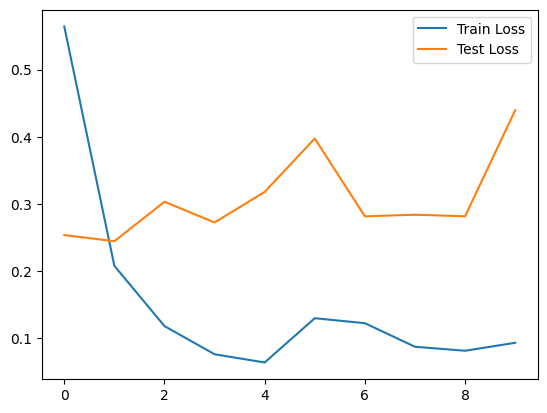

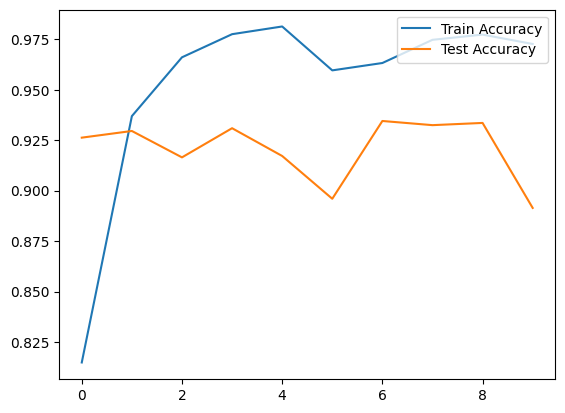

In [34]:
import matplotlib.pyplot as plt

#Evaluate the Model:
#using the Testing Dataset:
loss, accuracy = model.evaluate(test_data)
print(f'Loss: {loss}, Accuracy: {accuracy}')

#Loss Curve:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend(loc='upper right')
plt.show()

#Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='upper right')
plt.show()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [39]:
#check the data value
df['text'].sample(1).values[0]

'سوق دبي الي دول بقم 890 79 ملي نفذ 244 1 صفق وزع 560 67 ملي سهم ءغلق ءشر 180 480 1 نقط خفض قدر 210 8 شهد دول رفع 9 شرك هبط 16 شرك وثب سعر شرك شرك رفع تغر سعر شعع كابيتال ءغلاق 650 0 نسب تغر بلغ 4 كفل امر ءغلاق 540 0 نسب تغر بلغ 450 2 صرف سلم سود ءغلاق 480 1 نسب تغر بلغ 070 2 شرك دبي سلم تءم ءعد تءم ءغلاق 980 0 نسب تغر بلغ 140 1 دين مول ثمر ءغلاق 800 0 نسب تغر بلغ 010 1 بين كانت شرك خفض سعر بيت مول خلج ءغلاق 490 0 نسب تغر بلغ 170 3 مول ءغلاق 240 1 نسب تغر بلغ 130 3 شرك خلج ثمر عمة ءغلاق 330 0 نسب تغر بلغ 940 2 شرك وطن برد ركز برد ءغلاق 230 1 نسب تغر بلغ 380 2 وشر ربت قبض ءغلاق 820 2 نسب تغر بلغ 400 1 وفي علق شرك كثر نشط قيم دول فقد حقق مول دول بقم 870 556 732 24 جءت عمر عقر دول بقم 760 559 299 22 شرك وطن برد ركز برد دول بقم 140 306 438 6 جءت شرك بيت مول خلج دول بقم 740 769 972 4 جءت شرك ربت قبض دول بقم 460 380 988 2 نسب شرك كثر نشط حجم دول فقد تم دول 292 927 19 سهم مول 290 104 10 سهم بيت مول خلج 435 361 7 سهم عمر عقر 970 259 5 سهم شرك وطن برد ركز برد 657 750 3 سهم عرب طير'

In [40]:
#Create Test Sample:
test_sample = 'لذكاء الاصطناعي  هو مجال علوم الكمبيوتر المخصص لحل المشكلات المعرفية المرتبطة عادةً بالذكاء البشري، مثل التعلم والإبداع والتعرف على الصور. تجمع المؤسسات الحديثة كمياتٍ كبيرةً من البيانات من مصادر متنوعة مثل أجهزة الاستشعار الذكية والمحتوى الذي ينشئه الإنسان وأدوات المراقبة وسجلات النظام. الهدف من الذكاء الاصطناعي هو إنشاء أنظمة ذاتية التعلم تستخلص المعاني من البيانات. بعد ذلك، يُمكن للذكاء الاصطناعي تطبيق تلك المعرفة لحل المشكلات الجديدة بطرق تشبه الإنسان. على سبيل المثال، يُمكن لتقنية الذكاء الاصطناعي الاستجابة بشكل هادف للمحادثات البشرية، وإنشاء صور ونصوص أصلية، واتخاذ القرارات بناءً على مُدخلات البيانات في الوقت الفعلي. يمكن لمؤسستك دمج إمكانات الذكاء الاصطناعي في تطبيقاتك لتحسين عمليات الأعمال لديك وتحسين تجارب العملاء وتسريع الابتكار.'
test_sample = tokenizer.texts_to_sequences([test_sample])
test_sample = pad_sequences(test_sample, maxlen=max_len, padding='post')

In [41]:
#Model Prediction:
prediction = model.predict(test_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [42]:
#Interpreting Predictions:
pred = encoder.inverse_transform([prediction.argmax()])

#print before and after decoding
prediction, pred

(array([[3.9669307e-04, 4.3631703e-02, 1.7326653e-01, 4.5728646e-04,
         1.6940266e-04, 1.7477667e-05, 7.8206086e-01]], dtype=float32),
 array(['Tech'], dtype=object))

# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:



1.   First i filtered by text length to maintain a set a uniform length for the data. Then I built the clean_text function to remove links, remove special characters and punctuation, remove tashkeel and tatweel, delete stopwords and stemmed the words, finaly normalize the hamza. All of this to make the data accessible for the model because the model can't process all these things.

2.   It gave me the best accuracy and it ran efficiently.

3.   I wrote three bidirectional layers each time the neurons are lowered by one power it makes the flow good(it works perfectly everytime) then I added one dense layer with the same amount of neurons as the last bidirectional layer to processes and connect it to the last output layer which is catigorical.

4.   I used sparse_categorical_crossentropy loss because I am classifying 7 classes and accuracy as the metrics because it is classification.

5.   It is showing a bit of overfitting but it is good for a nlp classification model because the diffrence is less than 10%(training 0.9779 and testing 0.8947)

6.   Change the data and train it with more epochs.





